In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
plt.rcParams['figure.dpi']=200
plt.rcParams['mathtext.fontset']='cm'

# Sampler

We follow an algorithm based on the geneal rejection method suggested by [Tadikamalla 1979](https://link.springer.com/article/10.1007/BF02252098) that generates random variates from the two parameter generalized gamma distribution (GGD) having density 
$$ f(y;d,p) = \frac{p}{\Gamma(d/p)}y^{d-1}\exp(-y^p) $$
and we can make the transformation $x=ay$. Here we adopt the variable notation from [Wikipedia](https://en.wikipedia.org/wiki/Generalized_gamma_distribution), which is related to the paper's notation as $c\rightarrow p$, $\alpha \rightarrow d/p$ (the shape parameter), and $\beta\rightarrow a$. The proposed algorithm is
 * Set $A\equiv(d/p)^{1/p}$ and $B\equiv p(2d/p-1)^{1/2}$
 * Generate a pair of independent uniform random numbers in (0,1), $\xi_1$ and $\xi_2$
 * Set $V\equiv\ln(\xi_1/(1-\xi_1))/B$
 * If $\ln(\xi_1\xi_2(1-\xi_1))<=(d/p)-1.3862944 + dV - (d/p)e^{pV}$, deliver $x=Ae^V$, otherwise try again

In [3]:
def draw_distribution(N=100,d=2,p=1):
    from scipy.special import gamma
    
    A=(d/p)**(1/p)
    B=p*(2*(d/p)-1)**(1/2)
    print('===============================')
    print('Drawing random variates for GGD')
    print('===============================')
    print('parameters: d = {}, p = {}'.format(d,p))
    print('A = {}, B = {}'.format(A,B))
    Ntot=0
    yall=[]
    for i in range(20):
        xi1=np.random.rand(N)
        xi2=np.random.rand(N)
        V=np.log(xi1/(1-xi1))/B
        r=np.log(xi1*xi2*(1-xi1))
        T=(d/p)-1.3862944 + d*V - (d/p)*np.exp(p*V)
        accept=r<=T
        y=A*np.exp(V[accept])
        Ny=len(y)
        Ntot += Ny
        print('trial {}: N_accpeted = {}, N_tot = {}'.format(i,Ny,Ntot))
        yall.append(y)
        if Ntot > N: break
    return np.concatenate(yall)[:N]

In [4]:
@np.vectorize
def GGD(y,d=2,p=1):   
    from scipy.special import gamma
    return p/gamma(d/p)*y**(d-1)*np.exp(-y**p)

In [5]:
def plot_distribution(y,axes,d=2,p=1):
    y0=np.logspace(-4,2,100)
    
    plt.sca(axes[0])
    h=np.histogram(y,density=True,range=(0,10),bins=100)
    dbin=h[1][1]-h[1][0]
    l,=plt.step(h[1][:-1],h[0]/h[0].sum()/dbin,label='d={}, p={}'.format(d,p))
    plt.plot(y0,GGD(y0,d=d,p=p),color=l.get_color(),ls='--')
    plt.yscale('log')
    plt.ylim(1.e-3,5)
    plt.xlim(0,10)
    plt.xlabel(r'$y$')
    plt.ylabel(r'$f(y)$')

    plt.sca(axes[1])
    h=np.histogram(np.log10(y),density=True,range=(-4,2),bins=100)
    dbin=h[1][1]-h[1][0]
    l,=plt.step(h[1][:-1],h[0]/h[0].sum()/dbin)
    plt.plot(np.log10(y0),np.log(10)*y0*GGD(y0,d=d,p=p),color=l.get_color(),ls='--')
    plt.yscale('log')
    plt.ylim(1.e-3,5)
    plt.xlim(-3,1.5)
    plt.xlabel(r'$\log y$')
    plt.ylabel(r'$f(\log y)$')

Drawing random variates for GGD
parameters: d = 2, p = 1
A = 2.0, B = 1.7320508075688772
trial 0: N_accpeted = 793, N_tot = 793
trial 1: N_accpeted = 820, N_tot = 1613
Drawing random variates for GGD
parameters: d = 2.01, p = 4
A = 0.8419455706504377, B = 0.282842712474616
trial 0: N_accpeted = 69, N_tot = 69
trial 1: N_accpeted = 77, N_tot = 146
trial 2: N_accpeted = 73, N_tot = 219
trial 3: N_accpeted = 73, N_tot = 292
trial 4: N_accpeted = 81, N_tot = 373
trial 5: N_accpeted = 70, N_tot = 443
trial 6: N_accpeted = 56, N_tot = 499
trial 7: N_accpeted = 71, N_tot = 570
trial 8: N_accpeted = 82, N_tot = 652
trial 9: N_accpeted = 73, N_tot = 725
trial 10: N_accpeted = 63, N_tot = 788
trial 11: N_accpeted = 73, N_tot = 861
trial 12: N_accpeted = 69, N_tot = 930
trial 13: N_accpeted = 67, N_tot = 997
trial 14: N_accpeted = 70, N_tot = 1067
Drawing random variates for GGD
parameters: d = 3, p = 1
A = 3.0, B = 2.23606797749979
trial 0: N_accpeted = 837, N_tot = 837
trial 1: N_accpeted = 848

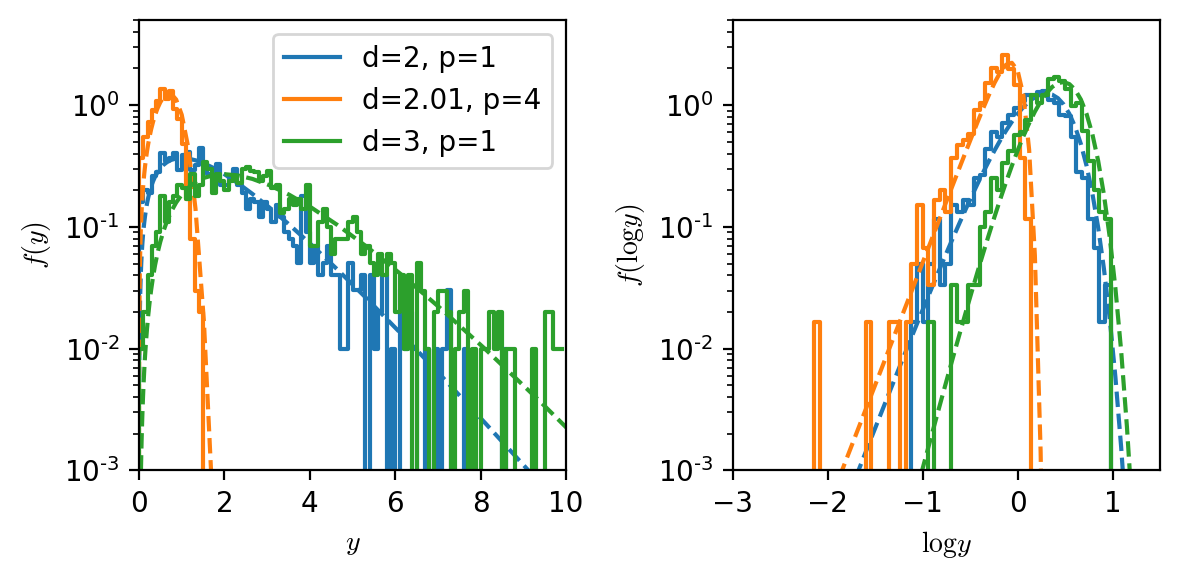

In [8]:
fig,axes = plt.subplots(1,2,figsize=(6,3))
for (d,p) in [[2,1],[2.01,4],[3,1]]:
    y=draw_distribution(1000,d=d,p=p)
    plot_distribution(y,axes,d=d,p=p)
axes[0].legend()
plt.tight_layout()

This generally works well, but the acceptance rate drops as $\alpha=d/p$ decreases and becomes zero for $\alpha<=1/2$!. Unfortunately, we have a case with $d=2$ and $p=4$ (for the Bernoulli velocity) so that $\alpha=1/2$. Then, I realized that we don't really need a general method to draw samples. We can pre-calculate and tabulate the inverse of CDF for three cases only since $d$ and $p$ are fixed!